In [ ]:
!pip install -q -U sagemaker ipywidgets

# ResNet-50 comparison: compiled vs uncompiled, featuring Inferentia

In this notebook we will see how to deploy a pretrained model from the PyTorch Vision library, in particular a ResNet50, to Amazon SageMaker. We will also test how it performs on different hardware configurations, and the effects of model compilation with Amazon SageMaker Neo. In a nutshell, we will test:

- ResNet50 on a ml.c5.xlarge, uncompiled
- ResNet50 on a ml.g4dn.xlarge, uncompiled
- ResNet50 on a ml.c5.xlarge, compiled
- ResNet50 on a ml.g4dn.xlarge, compiled
- ResNet50 on a ml.inf1.xlarge, compiled

**NOTE**: this notebook has been tested with the PyTorch 1.8 CPU kernel. Please use that one if you're using SageMaker Studio.

### Set-up model and SageMaker helper functions

In [ ]:
import sagemaker
from sagemaker import Session, get_execution_role
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.utils import name_from_base

print(sagemaker.__version__)

sess = Session()
bucket = sess.default_bucket()
role = get_execution_role()
endpoints = {}

Let's download the model for the PyTorch Hub, and create an archive that can be used by SageMaker to deploy this model. For using PyTorch in Script Mode, Amazon SageMaker expects a single archive file in `.tar.gz` format, containing a model file and the code for inference in a `code` folder. The structure of the archive will be as follows: 

```
/model.tar.gz
/--- model.pth
/--- code/
/--- /--- inference.py
/--- /--- requirements.txt (optional)
```

By setting the variable `download_the_model=False`, you can skip the download phase and provide your own path to S3 in the `model_data` variable.

In [ ]:
download_the_model = True

if download_the_model:
    import torch, tarfile
    # Load the model
    model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
    inp = torch.rand(1, 3, 224, 224)
    model_trace = torch.jit.trace(model, inp)
    # Save your model. The following code saves it with the .pth file extension
    model_trace.save('model.pth')
    with tarfile.open('model.tar.gz', 'w:gz') as f:
        f.add('model.pth')
        f.add('code/uncompiled-inference.py', 'code/inference.py')
    f.close()
    pytorch_resnet50_prefix = 'pytorch/resnet50'
    model_data = sess.upload_data('model.tar.gz', bucket, pytorch_resnet50_prefix)
else:
    pytorch_resnet50_prefix = 'pytorch/resnet50'
    model_data = f's3://{bucket}/{pytorch_resnet50_prefix}/model.tar.gz'
    
print(f'Model stored in {model_data}')

## Deploy and test on CPU

In our first test, we will deploy the model on a `ml.c5.xlarge` instance, without compiling the model. Although this is a CNN, it is still possible to run it on CPU, although the performances won't be that good. This can give us a nice baseline of the performances of our model.

In [ ]:
pth_model = PyTorchModel(model_data=model_data,
        entry_point='uncompiled-inference.py',
        source_dir='code',
        role=role,
        framework_version='1.7',
        py_version='py3'
)

In [ ]:
predictor = pth_model.deploy(1, 'ml.c5.xlarge')

In [ ]:
endpoints['cpu_uncompiled'] = predictor.endpoint_name
predictor.endpoint_name

## Deploy and test on GPU

The instance chosen this time is a `ml.g4dn.xlarge`. It has great throughput and the cheapest way of running GPU inferences on the AWS cloud.

In [ ]:
pth_model = PyTorchModel(model_data=model_data,
     entry_point='uncompiled-inference.py',
     source_dir='code',
     role=role,
     framework_version='1.6',
     py_version='py3'
)

In [ ]:
predictor = pth_model.deploy(1, 'ml.g4dn.xlarge')

In [ ]:
endpoints['gpu_uncompiled'] = predictor.endpoint_name
predictor.endpoint_name

# Compiled Models

A common tactic in more advanced use cases is to improve model performances, in terms of latency and throughput, by compiling the model. 

Amazon SageMaker features its own compiler, Amazon SageMaker Neo, that enables data scientists to optimize ML models for inference on SageMaker in the cloud and supported devices at the edge.

You start with a machine learning model already built with DarkNet, Keras, MXNet, PyTorch, TensorFlow, TensorFlow-Lite, ONNX, or XGBoost and trained in Amazon SageMaker or anywhere else. Then you choose your target hardware platform, which can be a SageMaker hosting instance or an edge device based on processors from Ambarella, Apple, ARM, Intel, MediaTek, Nvidia, NXP, Qualcomm, RockChip, Texas Instruments, or Xilinx. With a single click, SageMaker Neo optimizes the trained model and compiles it into an executable. 

For inference in the cloud, SageMaker Neo speeds up inference and saves cost by creating an inference optimized container in SageMaker hosting. For inference at the edge, SageMaker Neo saves developers months of manual tuning by automatically tuning the model for the selected operating system and processor hardware.

### Create the `model_data` for compilation

To compile the model, we need to provide a `tar.gz` archive just like before, with very few changes. In particular, since SageMaker will use a different DL runtime for running compiled models, we will let it use the default function for serving the model, and only provide a script containing how to preprocess data. Let's create this archive and uplaod it to S3.

In [ ]:
import tarfile 

with tarfile.open('model-to-compile.tar.gz', 'w:gz') as f:
    f.add('model.pth')
    f.add('code/compiled-inference.py', 'code/inference.py')
f.close()
model_data = sess.upload_data('model-to-compile.tar.gz', bucket, pytorch_resnet50_prefix)

In [ ]:
output_path = f's3://{bucket}/{pytorch_resnet50_prefix}/compiled'

## Compile for CPU

Let's run the same baseline test from before, and compile and deploy for CPU instances.

In [ ]:
pth_model = PyTorchModel(model_data=model_data,
        entry_point='compiled-inference.py',
        source_dir='code',
        role=role,
        framework_version='1.6',
        py_version='py3'
)

In [ ]:
output_path = f's3://{bucket}/{pytorch_resnet50_prefix}/compiled'

compiled_model = pth_model.compile(
    target_instance_family='ml_c5',
    input_shape={"input0": [1, 3, 224, 224]},
    output_path=output_path,
    role=role,
    job_name=name_from_base(f'pytorch-resnet50-c5')
)

In [ ]:
predictor = compiled_model.deploy(1, 'ml.c5.xlarge')

In [ ]:
endpoints['cpu_compiled'] = predictor.endpoint_name
predictor.endpoint_name

## Compile for GPU

In [ ]:
pth_model = PyTorchModel(model_data=model_data,
                     entry_point='compiled-inference.py',
                     source_dir='code',
                     role=role,
                     framework_version='1.6',
                     py_version='py3'
                    )

In [ ]:
output_path = f's3://{bucket}/{pytorch_resnet50_prefix}/compiled'

compiled_model = pth_model.compile(
    target_instance_family='ml_g4dn',
    input_shape={"input0": [1, 3, 224, 224]},
    output_path=output_path,
    role=role,
    job_name=name_from_base(f'pytorch-resnet50-g4dn')
)

In [ ]:
predictor = compiled_model.deploy(1, 'ml.g4dn.xlarge')

In [ ]:
endpoints['gpu_compiled'] = predictor.endpoint_name
predictor.endpoint_name

In [ ]:
print(1)

## Compile for Inferentia instances

There is one more thing we can try to improve our model performances: using Inferentia instances.

Amazon EC2 Inf1 instances deliver high-performance ML inference at the lowest cost in the cloud. They deliver up to 2.3x higher throughput and up to 70% lower cost per inference than comparable current generation GPU-based Amazon EC2 instances. Inf1 instances are built from the ground up to support machine learning inference applications. They feature up to 16 AWS Inferentia chips, high-performance machine learning inference chips designed and built by AWS.

In [ ]:
pth_model = PyTorchModel(
    model_data=model_data,
    entry_point='compiled-inference.py',
    source_dir='code',
    role=role,
    framework_version='1.7',
    py_version='py3'
)

In [ ]:
compiled_model = pth_model.compile(
    target_instance_family='ml_inf1',
    input_shape={"input0": [1, 3, 224, 224]},
    output_path=output_path,
    role=role,
    job_name=name_from_base(f'pytorch-resnet50-inf1'),
    compile_max_run=1000
)

In [ ]:
predictor = compiled_model.deploy(1, 'ml.inf1.xlarge')

In [ ]:
endpoints['inferentia'] = predictor.endpoint_name
predictor.endpoint_name

# Test

For testing our models and endpoints, we will use the following picture of a beagle pup, freely available on [Wikimedia](https://commons.wikimedia.org/wiki/File:Beagle_puppy_sitting_on_grass.jpg). We will pass it to our endpoints as `application/x-image`, and no particular pre-processing is needed on client-side. 

In [ ]:
from IPython.display import Image

Image('doggo.jpg')

Finally, we will use the following function to benchmark our SageMaker endpoints, measuring the latency of our predictions. This specific version uses both the `Predictor` from the SageMaker Python SDK and boto3's `invoke_endpoint()` function - just change the last parameter from `boto3` to `sm` if you want to use the Python SDK.

In [ ]:
from load_test import load_tester

num_thread = 16

from IPython.display import JSON
JSON(endpoints)

In [ ]:
# CPU - Uncompiled
load_tester(num_thread, endpoints['cpu_uncompiled'], 'doggo.jpg', 'boto3')

Let's discuss the above results:

as we can from the latency tests, the model way too long to generate an inference, averaging about 6 transactions per second (TPS). This of course may be sufficient for some low throughput use cases, rarely used instances, but it's very likely that it won't be sufficient. Let's see how those numbers change when using a GPU.

In [ ]:
# GPU - Uncompiled
load_tester(num_thread, endpoints['gpu_uncompiled'], 'doggo.jpg', 'boto3')

Now we're talking! The GPU helps us achieve 77 TPS on average, with a much lower latency percentile over the board. Nice!

In [ ]:
# CPU - Compiled
load_tester(num_thread, endpoints['cpu_compiled'], 'doggo.jpg', 'boto3')

With a simple compilation job, we more than DOUBLED the performances of our model on our c5 instance, achieving 13 TPS and half the latency percentiles. Let's see if the same results can be seen on GPU.

In [ ]:
# GPU - Compiled
load_tester(num_thread, endpoints['gpu_compiled'], 'doggo.jpg', 'boto3')

Results are also consistent in the compiled version of the model on GPU. Almost double the TPS, with 7 ms latency. Let's take it one step further and test Inferentia.

In [ ]:
# Inferentia
load_tester(num_thread, endpoints['inferentia'], 'doggo.jpg', 'boto3')

The best results so far! Up to 290 TPS at the same latency percentiles than GPU, or lower. All of this for a fraction of the cost.

# Reviewing the results

Let's plot the results obtained from the previous tests, by taking into account the last printed line of each load testing. We will ignore the error rate, and take into account the TPS obtained with our tests dividing it by the cost of the machine in the region of testing (DUB) - a metric we will call "throughput per dollar".

In [1]:
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd

data = StringIO('''
experiment|TPS|p50|cost/hour
c5|5.900|215.23876|0.23
c5 + Neo|12.900|121.60897|0.23
g4dn|74.700|21.19393|0.821
g4dn + Neo|140.400|11.28725|0.821
inf1|304.300|4.90315|0.33
''')

df = pd.read_csv(data, sep='|')
df['throughput per dollar (divided by 100, higher is better)'] = df['TPS']/df['cost/hour']/100 # Divide by 100 to normalize
df['cost per 1M inferences in $ (lower is better)'] = (1000000/df['TPS'])/3600*df['cost/hour']
df['number of inferences per dollar (higher is better)'] = df['TPS']*3600/df['cost/hour']
df['transactions per hour'] = df['TPS']*3600

df.head()

,experiment,TPS,p50,cost/hour,"throughput per dollar (divided by 100, higher is better)",cost per 1M inferences in $ (lower is better),number of inferences per dollar (higher is better),transactions per hour
0,c5,5.9,215.23876,0.230,0.256522,10.828625,9.234783e+04,21240.0
1,c5 + Neo,12.9,121.60897,0.230,0.560870,4.952627,2.019130e+05,46440.0
2,g4dn,74.7,21.19393,0.821,0.909866,3.052953,3.275518e+05,268920.0
3,g4dn + Neo,140.4,11.28725,0.821,1.710110,1.624327,6.156395e+05,505440.0
4,inf1,304.3,4.90315,0.330,9.221212,0.301238,3.319636e+06,1095480.0


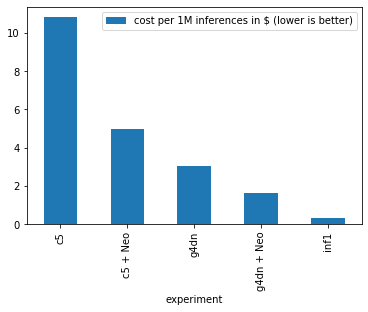

In [2]:
df.plot(x="experiment", y="cost per 1M inferences in $ (lower is better)", kind="bar")

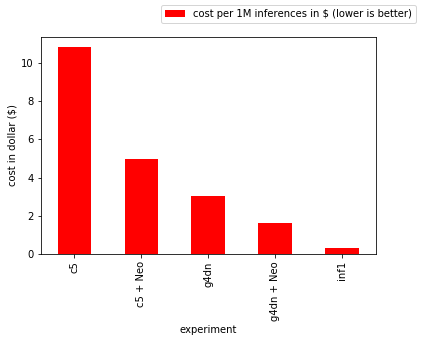

In [3]:
ax = df.plot(x="experiment", y="cost per 1M inferences in $ (lower is better)", legend=False, kind="bar", color="red", ylabel='cost in dollar ($)')
ax.figure.legend()
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('./images/cost-1M-inferences.png', dpi=300, format='png')
plt.show()

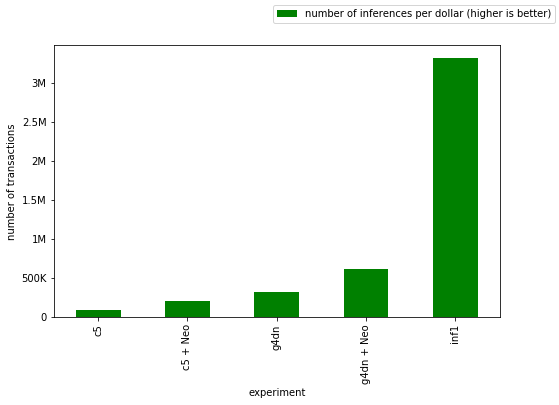

In [4]:
ax = df.plot(x="experiment", y="number of inferences per dollar (higher is better)", legend=False, kind="bar", color="green", ylabel="number of transactions")
ax.figure.legend()
plt.yticks([0,500000,1000000,1500000,2000000,2500000, 3000000], ["0", "500K", "1M", "1.5M", "2M", "2.5M", "3M"])
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('images/inferences-per dollar.png', dpi=300, format='png')
plt.show()

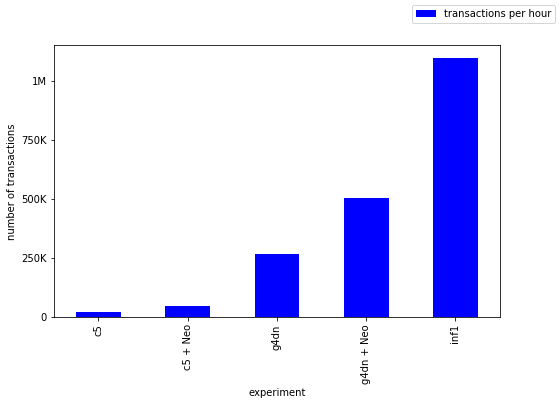

In [5]:
ax = df.plot(x="experiment", y="transactions per hour", legend=False, kind="bar", color="blue", ylabel="number of transactions")
ax.figure.legend()
plt.rcParams["figure.figsize"] = (8,5)
plt.yticks([0,250000,500000,750000, 1000000], ["0", "250K", "500K", "750K", "1M"])
plt.savefig('images/transactions-per-hour.png', dpi=300, format='png')
plt.show()

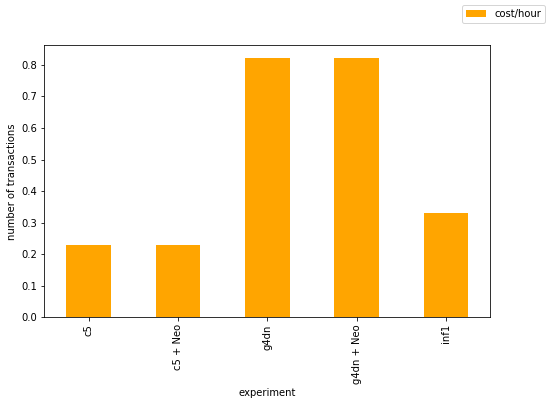

In [6]:
ax = df.plot(x="experiment", y="cost/hour", legend=False, kind="bar", color="orange", ylabel="number of transactions")
ax.figure.legend()
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('images/cost-per-hour.png', dpi=300, format='png')
plt.show()

The results speak for themselves. The `inf1` instance proves extremely competitive, thanks to its high TPS, incredibly low latency and undeniable value. Compiling the model for a GPU just like the `g4dn` is also a very interesting approach.

# Clean-up

In [ ]:
for endpoint in endpoints:
    pred = sagemaker.predictor.Predictor(endpoint_name=endpoints[endpoint])
    pred.delete_endpoint()